#📌 Extracción

In [11]:
import pandas as pd
import json

with open('/content/TelecomX_Data.json') as f:
    raw_data = json.load(f)

df_raw = pd.json_normalize(raw_data)




#🔧 Transformación

In [12]:
import logging

logging.basicConfig(filename='telecomx_etl.log', level=logging.INFO)

# Diagnóstico
mem_mb = df_raw.memory_usage(deep=True).sum() / (1024**2)
print(f"Memoria total: {mem_mb:.2f} MB")
logging.info(f'Memoria total: {mem_mb:.2f} MB')

# Limpieza
low_variance = [col for col in df_raw.columns if df_raw[col].nunique() <= 1]
high_cardinality = [col for col in df_raw.columns if df_raw[col].nunique() > 1000]
nested_cols = [col for col in df_raw.columns if df_raw[col].apply(lambda x: isinstance(x, (list, dict))).any()]
cols_to_drop = list(set(low_variance + high_cardinality + nested_cols))

df_clean = df_raw.drop(columns=cols_to_drop)
logging.info(f'Columnas eliminadas: {len(cols_to_drop)}')

Memoria total: 8.04 MB


#📊 Carga y análisis

In [13]:
df_clean.to_csv('telecomx_reducido.csv', index=False)
logging.info('Archivo telecomx_reducido.csv guardado exitosamente')



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

X = pd.get_dummies(X)
y = y.apply(lambda x: 1 if x == 'Yes' else 0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1082
           1       0.62      0.50      0.55       372

    accuracy                           0.79      1454
   macro avg       0.73      0.70      0.71      1454
weighted avg       0.78      0.79      0.78      1454



#📄Informe final

In [15]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)
print("Variables más influyentes en el churn:")
print(top_features)


Variables más influyentes en el churn:
customer.tenure                           0.267070
account.Contract_Month-to-month           0.061509
account.PaymentMethod_Electronic check    0.035510
customer.SeniorCitizen                    0.032933
internet.OnlineSecurity_No                0.032206
internet.TechSupport_No                   0.030165
internet.InternetService_Fiber optic      0.026605
customer.gender_Male                      0.025531
customer.gender_Female                    0.025195
internet.DeviceProtection_No              0.022636
dtype: float64


#Informe final
##teniendo en cuenta las variables: tipo de contrato, metodo de pago, servicios contratados, tenure y Churn_no las remendaciones son:                                                     -incentiivar contratos largos
##-mejorar servicios de soporte y seguridad
## -fidelizacion de clientes nuevos
## -monitorear clientes con pago electronico

#Parte Dos

##Extracción del Archivo Tratado

In [17]:
with open('/content/telecomx_reducido.csv') as f:
    df_raw = pd.read_csv(f)

##Eliminacion de culumnas irrelevantes

In [20]:
cols_to_drop = [col for col in low_variance + high_cardinality + nested_cols if col not in ['customerID', 'account.Charges.Monthly', 'account.Charges.Total']]
df_clean = df_raw.drop(columns=cols_to_drop)

##Encoding

In [21]:
X = pd.get_dummies(df_clean.drop('Churn', axis=1))
y = df_clean['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


##Verificación de la Proporción de Cancelación (Churn)

In [22]:
print(y.value_counts(normalize=True))


Churn
0    0.74281
1    0.25719
Name: proportion, dtype: float64


##Balanceo de Clases

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


##Normalización o Estandarización

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)


##Análisis de Correlación

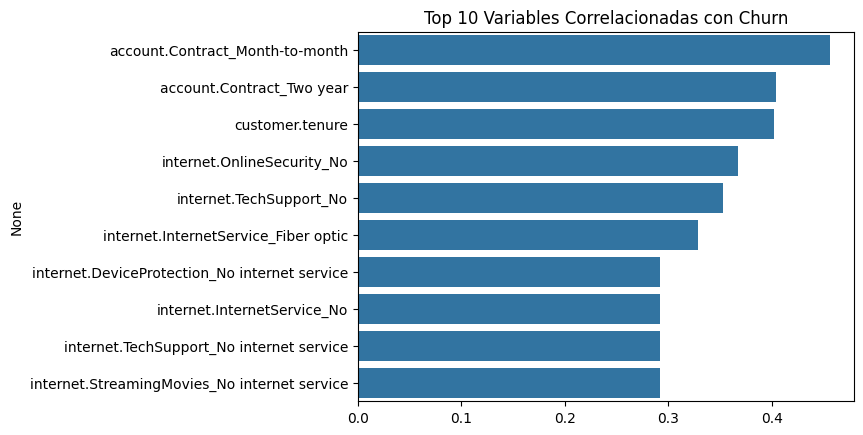

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corrwith(pd.Series(y_resampled)).abs()
top_features = corr_matrix.sort_values(ascending=False).head(10)
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Variables Correlacionadas con Churn")
plt.show()


##Análisis Dirigido
###Contract_Two year: contratos largos reducen cancelación

###MonthlyCharges: cargos mensuales altos aumentan cancelación

###TechSupport_No: falta de soporte técnico se asocia con mayor churn

###InternetService_Fiber optic: clientes con fibra óptica tienden a cancelar más

##Separación de Datos

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)


##Creación de Modelos

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Diccionario para almacenar modelos y sus nombres
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    print(f"\n🔍 Modelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(classification_report(y_test, y_pred))



🔍 Modelo: Random Forest
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1060
           1       0.84      0.86      0.85      1100

    accuracy                           0.84      2160
   macro avg       0.84      0.84      0.84      2160
weighted avg       0.84      0.84      0.84      2160


🔍 Modelo: Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1060
           1       0.86      0.83      0.85      1100

    accuracy                           0.85      2160
   macro avg       0.85      0.85      0.85      2160
weighted avg       0.85      0.85      0.85      2160


🔍 Modelo: XGBoost
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1060
           1       0.84      0.85      0.84      1100

    accuracy                           0.84      2160
   macro avg       0.84      0.84      0.84      2160

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:28:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##Conclusiones
###Factores Clave de Cancelación

####Clientes con contratos mensuales y sin soporte técnico tienen mayor probabilidad de cancelar.

####Cargos mensuales elevados y servicios de fibra óptica también se asocian con mayor churn.

###Estrategias de Retención

####Incentivar contratos largos con descuentos progresivos.

####Mejorar soporte técnico y visibilidad de asistencia.

####Segmentar clientes de alto riesgo para campañas personalizadas.

####Ofrecer planes escalonados para clientes con cargos mensuales altos.